<a href="https://colab.research.google.com/github/thdus5918647/DL/blob/main/Quantization_and_Pruning_on_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Tensorflow Lite: Getting Started**

First, download and normalize the fashion MNIST dataset

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


In [ ]:
# Load MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
# Normalize the input image
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28)),
    tf.keras.layers.Reshape(target_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])
# Compile and Train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(
    train_images,
    train_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

metrics = model.evaluate(test_images, test_labels)

Epoch 1/10
1875/1875 [==============================] - 60s 31ms/step - loss: 0.4755 - accuracy: 0.8315 - val_loss: 0.3631 - val_accuracy: 0.8728
Epoch 2/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3204 - accuracy: 0.8876 - val_loss: 0.3192 - val_accuracy: 0.8837
Epoch 3/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2808 - accuracy: 0.9005 - val_loss: 0.3090 - val_accuracy: 0.8913
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2550 - accuracy: 0.9086 - val_loss: 0.2840 - val_accuracy: 0.9028
Epoch 5/10
1875/1875 [==============================] - 48s 25ms/step - loss: 0.2358 - accuracy: 0.9153 - val_loss: 0.2686 - val_accuracy: 0.9052
Epoch 6/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.2197 - accuracy: 0.9213 - val_loss: 0.2581 - val_accuracy: 0.9098
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.2084 - accuracy: 0.9253 - val_loss: 0.2618 -

In [ ]:
print(f"Model test loss: {metrics[0]:.03f} | test accuracy: {metrics[1]*100:.02f}%")

Model test loss: 0.256 | test accuracy: 91.25%


학습된 모델을 변환하기 위해서는 TensorFlow Lite converter라는 것을 이용해야 합니다. 이것은 TensorFlow 모델을 TensorFlow Lite 모델로 바꿔 줍니다.

다음과 같이 tflite 모델로 변환할 수 있습니다.

To convert the model to TFLite, initialize a ***converter***

In [ ]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

변화할 때 아무런 옵션을 주지 않았으므로 이 모델은 단순히 32-bit float tflite 모델입니다.

We can now save the tflite model and deploy it on mobile!

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Next, we have several options available to optimize the model
- Typically, we use ***Tensorflow Model Optimization Toolkit***

Two methods:
- Quantization
  - Post-Training Quantization(PTQ)
  - Quantization-Aware Training(QAT)
- Pruning <br/>

다음 셀을 실행하면 quantization이 완료된다. 

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8

post_quant_tflite_model = converter.convert()


/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


evaluate을 위한 helper function이다. input typer을 integer로 했으므로, quantize를 한 다음에 inference를 한다.

In [ ]:
from tqdm import tqdm

def evaluate_model(interpreter):
  global test_images

  input_details = interpreter.get_input_details()[0]
  input_index = input_details["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" datset.
  prediction_digits = []
  for test_image in tqdm(test_images):
    # quantize input
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    # pre-processing: add batch dimension
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print()
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy, output

tflite 모델로 inference를 하려면 **`Interpreter`**를 이용한다. **`model_content`** 대신에 **`model_path`**를 이용하면 tflite 파일을 불러올 수도 있다.
<br/>
inference를 하기 위해서는 <br/>
interpreter 생성 -> **`allocate_tensor`** -> **`set_tensor`** -> **`invoke`** 순으로 실핸한다. <br/>
지금 코드는 inference할 때 image를 하나씩 처리하는데, batch 단위로 처리하려면 r**`esize_tensor_input`**을 이용한다.

In [ ]:
# 32bit float tflite 모델로 interpreter 만듦
interpreter = tf.lite.Interpreter(model_content=tflite_model)

# inference할 때 input batch 수를 설정하는 법
# input_details = interpreter.get_input_details()[0]
# interpreter.resize_tensor_input(input_details["index"], [10, 28, 28] )

interpreter.allocate_tensors()
tflite_test_accuracy, _ = evaluate_model(interpreter)

# 8bit integer tflite
post_quant_interpreter = tf.lite.Interpreter(model_content=post_quant_tflite_model)
post_quant_interpreter.allocate_tensors()
post_quant_tflite_test_accuracy, output = evaluate_model(post_quant_interpreter)

100%|██████████| 10000/10000 [00:04<00:00, 2449.97it/s]


100%|██████████| 10000/10000 [00:01<00:00, 5332.14it/s]

**`get_input_details`**, **`get_output_details`**를 통해 input과 output의 type 및 quantization 정보를 알 수 있다.

In [ ]:
post_quant_interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([-1, 28, 28], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
post_quant_interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 24,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

실제로 inference output이 정수임을 확인할 수 있다.

In [ ]:
print(output())

[[  0   0   0   0   0 192   0  56   8   0]]


float 32 모델과 accuracy를 비교해 보자.

In [ ]:
print('TFLite test accuracy: ', tflite_test_accuracy)
print('Post-training Quant TFLite test_accuracy: ', post_quant_tflite_test_accuracy) # 비슷하거나 조금 떨어지는 것이 정상임

TFLite test accuracy:  0.9125
Post-training Quant TFLite test_accuracy:  0.9124


모델을 파일로 저장해서 실제로 모델 크기가 줄어들었는지 확인해 보자.

In [ ]:
import tempfile
import os

# create temp file
_, tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_tflite_file = tempfile.mkstemp('.tflite')

# tflite model 저장
with open(tflite_file, 'wb') as f:
  f.write(tflite_model)

with open(post_quant_tflite_file, 'wb') as f:
  f.write(post_quant_tflite_model)

tflite_size = os.path.getsize(tflite_file) / float(2**20)
quantized_size = os.path.getsize(post_quant_tflite_file) / float(2**20)

print(f"Float model: {tflite_size:.03f} MB")
print(f"Quantized model: {quantized_size:.03f} MB")
print(f"Quantized model: {quantized_size/tflite_size:.02f} x Float model size",)

Float model: 0.082 MB
Quantized model: 0.025 MB
Quantized model: 0.31 x Float model size


### **실습: TensorFlow에서 제공하는 pretrain model 가져와서 post-training quantization 해보기**

TensorFlow에서는 여러 pretrained model을 제공한다. 아무거나 하나 가져와서 post-training quantization을 해보자.

In [ ]:
# pretrain 모델 import 하기.
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
from IPython.display import display

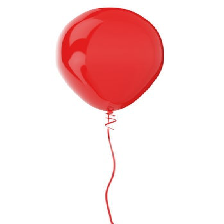

In [ ]:
url = "https://cdn.education.com/files/526001_527000/526114/file_526114.jpg"
os.system("curl " + url + " > balloon.jpg")
img_path = 'balloon.jpg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # 각 모델을 학습할 때 preprocess했던 방법 사용

evaluate 할 때는 다음 함수를 이용

In [ ]:
def evaluate_model_practice(interpreter, test_images):
  input_details = interpreter.get_input_details()[0]
  input_index = input_details["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in tqdm(test_images):
    # quantize input
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point
    
    # Pre-processing: add batch dimension
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    preds = interpreter.tensor(output_index)
    preds = np.expand_dims(preds()[0], axis=0)

  return preds

In [ ]:
# 1. import한 pretrain 모델 가져오기
imagenet = ResNet50(weights='imagenet')

preds = imagenet.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted: ', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 2s 2s/step
Predicted:  [('n02782093', 'balloon', 0.9505768), ('n04023962', 'punching_bag', 0.03517213), ('n03544143', 'hourglass', 0.0015566874)]


크기 비교를 위한 32bit float tflite 모델

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(imagenet) # resnet50 tflite 변환 = 32bit float 형식
imagenet_tflite = converter.convert()

In [ ]:
# 2. full integer post-training quantization
import numpy as np
def representative_data_gen():
  yield [x] # test할 이미지 1개만 사용

converter = tf.lite.TFLiteConverter.from_keras_model(imagenet)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

post_quant_imagenet_tflite = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
# 3. make interpreter and do inference
# tflite 모델로 interpreter 만듦
post_quant_imagenet_interpreter = tf.lite.Interpreter(model_content=post_quant_imagenet_tflite)

post_quant_imagenet_interpreter.allocate_tensors()

preds = evaluate_model_practice(post_quant_imagenet_interpreter, x)
print('\nPredicted: ', decode_predictions(preds, top=3)[0])

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Predicted:  [('n02782093', 'balloon', 245), ('n04023962', 'punching_bag', 7), ('n03942813', 'ping-pong_ball', 1)]


In [ ]:
# Measure sizes of models.
_, imagenet_tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_imagenet_tflite_file = tempfile.mkstemp('.tflite')

with open(tflite_file, 'wb') as f:
  f.write(imagenet_tflite)

with open(post_quant_tflite_file, 'wb') as f:
  f.write(post_quant_imagenet_tflite)

tflite_qat_size = os.path.getsize(tflite_file) / float(2**20)
quantized_size = os.path.getsize(post_quant_tflite_file) / float(2**20)

print(f"Float model: {tflite_qat_size:.03f} MB")
print(f"Quantized model: {quantized_size:.03f} MB")
print(f"Quantized model: {quantized_size/tflite_qat_size:.02f} x Float model size",)

Float model: 97.430 MB
Quantized model: 25.079 MB
Quantized model: 0.26 x Float model size


## **Quantization Aware Training(QAT)** <br/>
QAT는 나중에 quantization을 할 것이라는 것을 가정하고 학습하는 것이다. <br/>
scratch부터 학습해도 되지만, 이미 학습된 모델을 fine tuning하는 것이 좋다고 한다. 

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

### **Quantize whole model**<br/>
Edge TPU와 같이 fully quantized 모델이 필요한 경우에는 전체 모델에 대해 QAT를 한다.<br/>
위에서 학습한 float32모델로 QAT를 해볼 것이다.<br/>
`quantize_model` 함수를 이용한다.

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)

# 'quantize_model' requires a recompile.
quant_aware_model.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

quant_aware_model.summary() # 모든 layer가 quantize로 변하는 것을 확인할 수 있음

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_reshape (QuantizeWrap  (None, 28, 28, 1)        1         
 perV2)                                                          
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 28, 28, 16)       195       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 14, 14, 16)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 14, 32)       4

layer에 quant가 붙은 것을 확인할 수 있다. </br>
그 다음으로는, data의 일부를 이용해서 fine tuning한다.

In [ ]:
# data 일부를 이용해서 fine tuning
train_images_subset = train_images[0:1000] # out ot 60000
train_labels_subset = train_labels[0:1000]

quant_aware_model.fit(train_images, train_labels, batch_size=500, epochs=10, validation_split=0.1)
model.fit(train_images, train_labels, batch_size=500, epochs=10, validation_split=0.1)

Epoch 1/10
108/108 [==============================] - 39s 340ms/step - loss: 0.1554 - accuracy: 0.9449 - val_loss: 0.1440 - val_accuracy: 0.9492
Epoch 2/10
108/108 [==============================] - 38s 357ms/step - loss: 0.1483 - accuracy: 0.9481 - val_loss: 0.1481 - val_accuracy: 0.9450
Epoch 3/10
108/108 [==============================] - 38s 351ms/step - loss: 0.1455 - accuracy: 0.9491 - val_loss: 0.1449 - val_accuracy: 0.9475
Epoch 4/10
108/108 [==============================] - 36s 337ms/step - loss: 0.1433 - accuracy: 0.9492 - val_loss: 0.1485 - val_accuracy: 0.9447
Epoch 5/10
108/108 [==============================] - 36s 335ms/step - loss: 0.1406 - accuracy: 0.9505 - val_loss: 0.1532 - val_accuracy: 0.9462
Epoch 6/10
108/108 [==============================] - 37s 338ms/step - loss: 0.1375 - accuracy: 0.9520 - val_loss: 0.1528 - val_accuracy: 0.9463
Epoch 7/10
108/108 [==============================] - 36s 336ms/step - loss: 0.1374 - accuracy: 0.9521 - val_loss: 0.1522 - val_ac

아직 quantization을 하지 않았으므로 weight은 실수이다.

In [ ]:
quant_aware_model.layers[2].get_weights()

[array([[[[ 3.20332319e-01, -4.10334051e-01,  2.16265187e-01,
           -3.74895692e-01, -4.31641817e-01, -1.99177772e-01,
           -3.91042471e-01,  4.38113570e-01,  3.69700909e-01,
            3.63705941e-02,  1.00494556e-01,  5.29972911e-01,
           -1.78167149e-01, -2.04178263e-02,  2.17097588e-02,
           -1.02739464e-02]],
 
         [[ 1.53704165e-02,  3.04935109e-02, -1.92629382e-01,
            2.15839177e-01,  3.99846017e-01,  1.03315469e-02,
            1.46673262e-01, -2.19875187e-01,  4.52047348e-01,
           -4.75671262e-01,  2.60078646e-02, -3.45883548e-01,
            4.23887849e-01,  1.79081619e-01, -1.77454129e-02,
           -4.51611251e-01]],
 
         [[-1.04765901e-02,  2.41397440e-01,  1.15572913e-02,
            1.03852404e-02,  2.50991806e-02,  3.56819178e-03,
            2.75381774e-01, -9.66981724e-02,  4.36247677e-01,
            4.97107118e-01, -4.82433215e-02, -2.05285954e+00,
           -4.07880902e-01, -7.31886327e-02,  1.94218650e-01,
      

실수 weight이므로 QAT를 한다고 해서 accuracy가 떨어지지 않는다.

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, quant_aware_model_accuracy = quant_aware_model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('QAT test accuracy:', quant_aware_model_accuracy)

Baseline test accuracy: 0.9185000061988831
QAT test accuracy: 0.9182999730110168


이제 QAT로 학습한 모델을 quantization해보자.</br>
post-training quantization과 비슷하게 TFLiteConverter를 이용하면 된다.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8

QAT_tflite_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


quantization을 해도 accuracy가 떨어지지 않는 것을 알 수 있다.

In [ ]:
QAT_interpreter = tf.lite.Interpreter(model_content=QAT_tflite_model)
QAT_interpreter.allocate_tensors()

QAT_test_accuracy, output = evaluate_model(QAT_interpreter)

print('Baseline teset accuracy: ', baseline_model_accuracy) # 1
print('Post-training Quantized test accuracy: ', post_quant_tflite_test_accuracy) # 3
print('Quantization-Aware Training test accuracy: ', QAT_test_accuracy) # 2

100%|██████████| 10000/10000 [00:01<00:00, 5134.55it/s]


Baseline teset accuracy:  0.9185000061988831
Post-training Quantized test accuracy:  0.9124
Quantization-Aware Training test accuracy:  0.9176


마찬가지로 크기가 1/4로 줄어든 것을 알 수 있다.

In [ ]:
# create temp file
_, QAT_tflite_file = tempfile.mkstemp('.tflite')

with open(QAT_tflite_file, 'wb') as f:
  f.write(QAT_tflite_model)

quantized_size = os.path.getsize(QAT_tflite_file) / float(2**20)

print(f"Float tflite model: {tflite_size:.03f} MB")
print(f"Quantized QAT model: {quantized_size:.03f} MB")
print(f"Quantized QAT model: {quantized_size/tflite_size:0.2f} x Float model size",)

Float tflite model: 0.082 MB
Quantized QAT model: 0.026 MB
Quantized QAT model: 0.32 x Float model size


### **Quantize some layers </br>**
Edge TPU 등 특별한 하드웨어가 아닌 경우에는 선택적으로 layer를 quantization할 수도 있다. </br></br>
**Tips for better accuracy** </br>
- from scratch 보다는 fine tuning
- 뒤쪽 layer를 quantization하기
- 특별히 중요한 layer는 quantization 피하기 

</br>

`quantize_annotate_layer` 함수를 이용해서 특정 layer를 quantization할 것이라고 표시한다.

In [ ]:
model.layers # 전체 layer 확인

In [ ]:
model.layers[-1].name

'dense'

In [ ]:
# Helper Function
def apply_quantization_to_dense(layer):
  # if isinstance(layer, tf.keras.layers.Dense)
  if layer.name == 'dense':
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  else:
    return layer

`clone_model` 함수와 helper function을 이용해서 annotated model을 만들고, `quantize_apply` 함수를 이용해서 QAT를 위한 모델을 만들면 된다.

In [ ]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 1568)             1

만약 fine tuning이 아니라 처음부터 모델을 만드는 것이면 다음과 같이 모델을 만들면 된다.
<br/><br/>

**Sequential example**

In [ ]:
annotated_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(10))    
])
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 12)       0         
 2D)                                                             
                                                                 
 quant_flatten_1 (QuantizeWr  (None, 2028)             1         
 apperV2)                                                        
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               20295     
 perV2)                                                          
                                                      

**Functional example**

In [ ]:
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(inputs)
x = tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

annotated_model = tf.keras.Model(inputs=inputs, outputs=outputs)
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 quant_reshape_2 (QuantizeWr  (None, 28, 28, 1)        1         
 apperV2)                                                        
                                                                 
 quant_conv2d_3 (QuantizeWra  (None, 26, 26, 12)       147       
 pperV2)                                                         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 12)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2028)              0         
                                                             

## **Pruning** <br/>
pruning은 불필요한(0에 가까운) weight을 0으로 만들어 없애면서 optimize를 한다. <br/>

`tfmot.sparsity.keras.prune_low_magnitude`을 이용해서 모델을 만든다. 이 때, pruning 방식인 <br/>
`tfmot.sparsity.keras.PolynomialDecay` 을 parameter로 넘겨준다. 다음과 같은 hyperparameter가 있다.
- `initial_sparsity` : pruning을 시작할 때의 sparsity를 몇으로 할 지
- `final_sparsity` : pruning을 끝낼 때의 sparsity를 몇으로 할 지
- `begin_step` : pruning을 언제부터 진행할 지 (batch 단위의 step)
- `end_step` : pruning을 언제 끝낼 지

<br/>
pruning을 하기 전에 baseline model을 저장하겠다. (크기 비교시 사용)

In [ ]:
_, baseline_model_accuracy = model.evaluate(test_images, test_labels, verbose=0)

print('Baseline test accuracy: ', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to: ', keras_file)

Baseline test accuracy:  0.9185000061988831
Saved baseline model to:  /tmp/tmpq_lhjvs8.h5


In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras.prune import prune_low_magnitude
# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule' : tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                              final_sparsity=0.80,
                                                              begin_step=0,
                                                              end_step=end_step)
}

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
model_for_pruning = prune_low_magnitude(model, **pruning_params) # model 전체 pruning 적용 진행

# 'prune_low_magnitude' requires a recompile.
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshape  (None, 28, 28, 1)        1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_conv2d   (None, 28, 28, 16)       306       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 14, 14, 16)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 14, 32)       9250      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 7, 7, 32)         1

fit을 할 때, `tfmot.sparsity.keras.UpdatePruningStep`을 callback으로 불러야 한다.

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                      callbacks=callbacks)

Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


422/422 [==============================] - 42s 89ms/step - loss: 0.2492 - accuracy: 0.9096 - val_loss: 0.2809 - val_accuracy: 0.8958
Epoch 2/2
422/422 [==============================] - 34s 81ms/step - loss: 0.2705 - accuracy: 0.9033 - val_loss: 0.2605 - val_accuracy: 0.9018


baseline 모델과 accuracy를 비교해 보자.

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose = 0)

print('Baseline test accuracy : ', baseline_model_accuracy)
print('Pruned test accuracy : ', model_for_pruning_accuracy)

Baseline test accuracy :  0.9185000061988831
Pruned test accuracy :  0.8945000171661377


pruned model의 크기가 줄어들었는 지 확인해 보자. <br/>

위에 summary를 보면 pruning을 하기 위해 non-trainable parameter가 생긴 것을 알 수 있다. <br/>
`tfmot.sparsity.keras.strip_pruning`을 이용해서 pruning에 사용한 variable을 제거해 준다.

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to: ', pruned_keras_file)

Saved pruned Keras model to:  /tmp/tmpakp2pe4m.h5


tflite으로 저장

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflie')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to: ', pruned_tflite_file)

Saved pruned TFLite model to:  /tmp/tmpgu5fwq4f.tflie


pruning을 해도 weight matrix의 크기는 그대로이다. 하지만 matrix의 값이 대부분 0이기 때문에 감소된 크기를 확인하려면 실제로 zip 파일 등으로 압축하는 과정을 거쳐야 한다.

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bites.
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 78982.00 bytes
Size of gzipped pruned Keras model: 26795.00 bytes
Size of gzipped pruned TFlite model: 25489.00 bytes


## **Combine pruning and quantization**

pruning을 한 다음에 post-training quantization까지 하면 크기를 더 줄일 수 있다.



In [ ]:
from tensorflow.python.util.nest import yield_flat_paths
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to: ', quantized_and_pruned_tflite_file)

print('Size of gzipped baseline Keras model: %.2f bytes' % (get_gzipped_model_size(keras_file)))
print('Size of gzipped pruned and quantized TFlite model: %.2f bytes' % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))
print(f"Size of optimized model is {get_gzipped_model_size(quantized_and_pruned_tflite_file)/get_gzipped_model_size(keras_file)} of the baseline model") # 12%

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Saved quantized and pruned TFLite model to:  /tmp/tmpr56qehal.tflite
Size of gzipped baseline Keras model: 78982.00 bytes
Size of gzipped pruned and quantized TFlite model: 9720.00 bytes
Size of optimized model is 0.12306601504140184 of the baseline model


baseline과 accuracy를 비교해 보자

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy, _ = evaluate_model(interpreter)

print('Baseline test accuracy: ', baseline_model_accuracy)
print('Pruned and quantized TFLite test_accuracy: ', test_accuracy) # 모델 크기는 기존 모델의 12%밖에 안되는데, 성능은 많이 안떨어짐을 확인함.

100%|██████████| 10000/10000 [00:02<00:00, 3496.35it/s]


Baseline test accuracy:  0.9185000061988831
Pruned and quantized TFLite test_accuracy:  0.894


QAT와 비슷하게, pruning도 layer를 선택적으로 pruning할 수 있다.